# Import Packages

In [4]:
# !pip3 install statsmodels

In [1]:
import os
import math
import re
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product

#For proper display of all columns
from IPython.display import display
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")
import gc



from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import scipy.stats as stats

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import RandomForestRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.init as init



# !pip3 install catboost
# from catboost import CatBoostRegressor, Pool

In [2]:
# Function to check the missing value count and percentage
def missing_val_check(data):
    """
    Input::data - A pandas dataframe
    Output::Missing value report by column
    """
    # Missing data check
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()
               ).sort_values(ascending=False)
    missing_data = pd.concat(
        [total, percent * 100], axis=1, keys=["Total", "Percent(%)"]
    )
    return missing_data


def get_box_plot(train):
    cont_cols = list(train._get_numeric_data().columns)
    fig, ax = plt.subplots(nrows=len(cont_cols) // 2 +
                           1, ncols=2, figsize=(10, 10))

    def func(x): return x.replace("_", " ").capitalize()
    cols_corrected = list(map(func, cont_cols))

    var_idx = 0

    for i in range(len(cont_cols) // 2 + 1):
        for j in range(2):
            try:
                sns.boxplot(train[cont_cols[var_idx]],
                            ax=ax[i][j], color="red")
                ax[i][j].set_xlabel(cols_corrected[var_idx])
                var_idx += 1
            except:
                break

    fig.suptitle("Box plots for outliers")


# Data Pre-Processing

### Load the dataset

In [3]:
audiodf = pd.read_csv('./spotify_songs.csv')
# Creating a duration feature coverted to minutes for intuitive understanding

audiodf['duration_ms'] = audiodf['duration_ms'] / 60000
audiodf = audiodf.rename(columns = {'duration_ms':'duration_mins','track_popularity':'popularity'})
# audiodf.drop(['duration_ms'],axis = 1, inplace = True)

print(audiodf.shape)
print(audiodf.columns)


(32833, 23)
Index(['track_id', 'track_name', 'track_artist', 'popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_mins'],
      dtype='object')


In [4]:
audiodf.head(5).T

,0,1,2,3,4
track_id,6f807x0ima9a1j3VPbc7VN,0r7CVbZTWZgbTCYdfa2P31,1z1Hg7Vb0AhHDiEmnDE79l,75FpbthrwQmzHlBJLuGdC7,1e8PAfcKUYoKkxPhrHqw4x
track_name,I Don't Care (with Justin Bieber) - Loud Luxur...,Memories - Dillon Francis Remix,All the Time - Don Diablo Remix,Call You Mine - Keanu Silva Remix,Someone You Loved - Future Humans Remix
track_artist,Ed Sheeran,Maroon 5,Zara Larsson,The Chainsmokers,Lewis Capaldi
popularity,66,67,70,60,69
track_album_id,2oCs0DGTsRO98Gh5ZSl2Cx,63rPSO264uRjW1X5E6cWv6,1HoSmj2eLcsrR0vE9gThr4,1nqYsOef1yKKuGOVchbsk6,7m7vv9wlQ4i0LFuJiE2zsQ
track_album_name,I Don't Care (with Justin Bieber) [Loud Luxury...,Memories (Dillon Francis Remix),All the Time (Don Diablo Remix),Call You Mine - The Remixes,Someone You Loved (Future Humans Remix)
track_album_release_date,2019-06-14,2019-12-13,2019-07-05,2019-07-19,2019-03-05
playlist_name,Pop Remix,Pop Remix,Pop Remix,Pop Remix,Pop Remix
playlist_id,37i9dQZF1DXcZDD7cfEKhW,37i9dQZF1DXcZDD7cfEKhW,37i9dQZF1DXcZDD7cfEKhW,37i9dQZF1DXcZDD7cfEKhW,37i9dQZF1DXcZDD7cfEKhW
playlist_genre,pop,pop,pop,pop,pop


### Duplicates checks as per track_id

In [5]:
print("Total Duplicates on the basis of tracks in the data" , audiodf[audiodf.duplicated(subset = 'track_id')].shape[0])

Total Duplicates on the basis of tracks in the data 4477


### Lets look at the data statistics

In [6]:
audiodf.describe([.1,.25,.5,.75,.9,.99]).T

,count,mean,std,min,10%,25%,50%,75%,90%,99%,max
popularity,32833.0,42.477081,24.984074,0.000000,2.000000,24.000000,45.000000,62.000000,74.000000,89.000000,100.000000
danceability,32833.0,0.654850,0.145085,0.000000,0.456000,0.563000,0.672000,0.761000,0.830000,0.926000,0.983000
energy,32833.0,0.698619,0.180910,0.000175,0.448000,0.581000,0.721000,0.840000,0.918000,0.982000,1.000000
key,32833.0,5.374471,3.611657,0.000000,0.000000,2.000000,6.000000,9.000000,10.000000,11.000000,11.000000
loudness,32833.0,-6.719499,2.988436,-46.448000,-10.688800,-8.171000,-6.166000,-4.645000,-3.541200,-1.924640,1.275000
mode,32833.0,0.565711,0.495671,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
speechiness,32833.0,0.107068,0.101314,0.000000,0.032600,0.041000,0.062500,0.132000,0.264000,0.448000,0.918000
acousticness,32833.0,0.175334,0.219633,0.000000,0.002180,0.015100,0.080400,0.255000,0.515000,0.894000,0.994000
instrumentalness,32833.0,0.084747,0.224230,0.000000,0.000000,0.000000,0.000016,0.004830,0.352000,0.917000,0.994000
liveness,32833.0,0.190176,0.154317,0.000000,0.068700,0.092700,0.127000,0.248000,0.372800,0.801000,0.996000


**Conclusion**:
The stats looks fine however some of features might contain outlier which needs to be taken care of.

1. Majority of songs have a duration of 3.6 mins however some of the songs have the duration greater than 10 mins which needs to be treated. We can see the 99th percentile value to be close to 9.54 minutes. Lets remove all the songs greater than 10 mins of duration. 

2. In some songs, tempo is 0 which is not possible hence a potential anomoly in the data, hence such value will add noise to our model. We will be taking all songs with tempo > 0

3. In some songs, duration is < 1 min. As per our research songs have minimum duration of 1 mins else its not a song it is an abstract of the same. Hence we will remove the songs with < 1min of duration.

4. Songs which have liveliness over 0.8 are mostly live performances hence it should be removed

5. We see that there is no key with value of -1. This means that all the tracks that we have, contain a well-detected key value.

In [7]:
class Data_Preprocessing_SP(object):
    def __init__(self, data = None, subset_on = None, keep='first', song_duration_min_cutoff = 1, speechiness_cutoff = 0.66, liveness_cutoff = 0.8):
        self.data = data
        self.subset_on = subset_on
        self.keep = keep
        self.song_duration_min_cutoff = song_duration_min_cutoff
        self.speechiness_cutoff = speechiness_cutoff
        self.liveness_cutoff = liveness_cutoff
    
    def duplicate_removal(self):
        """
        Removes duplicate on a primary key given
        """
        print("\n1. Duplicate Data Check & Removal if any")
        print("\nTotal duplicates on {} level are {}".format(self.subset_on, self.data[self.data.duplicated(subset = 'track_id')].shape[0]))
        
        self.data = self.data.drop_duplicates(subset = ['track_id'], keep = self.keep).reset_index(drop = True)
        
        print("\nTotal duplicates on {} level post treatment: {}".format(self.subset_on, self.data[self.data.duplicated(subset = 'track_id')].shape[0]))
        print("\nDuplicate Data treated")
        return self.data
        
    def intuitive_outlier_removal(self):
        print("\n2. Outlier removing engine started")
        
        print("\nRemoving outliers in duration (mins) of songs")
        self.data = self.data.query(f"duration_mins>={self.song_duration_min_cutoff}")
        
        print("\nRemoving songs with 0 tempo and time signature and songs with 0 popularity")
        self.data = self.data.query(f"tempo>0 and popularity>0")

        print("\nRemoving songs with speechiness over 0.66")
        self.data = self.data.query(f"speechiness<{self.speechiness_cutoff}")

        print("\nRemoving songs with liveness less than 0.8")
        self.data = self.data.query(f"liveness<{self.liveness_cutoff}")
        
        print("\nIntuitive outliers removed")
        return self.data

    
    def runner(self):
        print("=====Data Preprocessing on Song Polularity Data started====")
        self.data = self.duplicate_removal()
        self.data = self.intuitive_outlier_removal()
        print("\n=====Data Preprocessing on Song Polularity Data completed====")
        return self.data

**Run the preprocessor on our dataframe to prepare the data for analysis**

In [8]:
audiodf = Data_Preprocessing_SP(
    data = audiodf, 
    subset_on = 'track_id', 
    keep='first', 
    song_duration_min_cutoff = 1,
    speechiness_cutoff = 0.66 
).runner()

=====Data Preprocessing on Song Polularity Data started====

1. Duplicate Data Check & Removal if any

Total duplicates on track_id level are 4477

Total duplicates on track_id level post treatment: 0

Duplicate Data treated

2. Outlier removing engine started

Removing outliers in duration (mins) of songs

Removing songs with 0 tempo and time signature and songs with 0 popularity

Removing songs with speechiness over 0.66

Removing songs with liveness less than 0.8

Intuitive outliers removed

=====Data Preprocessing on Song Polularity Data completed====


In [9]:
audiodf.describe(include = ['O']).T

,count,unique,top,freq
track_id,25450,25450,6f807x0ima9a1j3VPbc7VN,1
track_name,25450,21262,Breathe,17
track_artist,25450,9950,Queen,127
track_album_id,25450,20479,246E5OvV4QXhPrGOSj7vdb,17
track_album_name,25450,18124,Greatest Hits,117
track_album_release_date,25450,4220,2020-01-10,197
playlist_name,25450,448,Indie Poptimism,273
playlist_id,25450,470,5vIdb67lQcdFwoVkE4UMep,100
playlist_genre,25450,6,rap,4906
playlist_subgenre,25450,24,indie poptimism,1435


In [10]:
# Cleaned data
audiodf[audiodf['track_name']=='Intro']

,track_id,track_name,track_artist,popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,playlist_subgenre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins
3875,0bXpmJyHHYPk6QBFj25bYF,Intro,The xx,72,2nXJkqkS1tIKIyhBcFMmwz,xx,2009-08-16,Indie/Jazz Poptimism,6OaTudLqBEuTyUMPxRNpZc,pop,indie poptimism,0.617,0.778,9,-8.871,0,0.0270,0.45900,0.925,0.1280,0.152,100.363,2.132000
5791,7tbyiwnLhtKYXNMjCZ60BT,Intro,Quality Control,59,1y1l71S4ZveVZQRuqcZk0u,Intro,2019-08-01,Hip Hop Controller,37i9dQZF1DWT5MrZnPU1zD,rap,hip hop,0.880,0.569,2,-5.497,1,0.2740,0.14100,0.000,0.6730,0.141,137.024,3.589083
7904,2emsHMLGBFHEbd6Z2svnF0,Intro,DJ Drama,19,5GQLnmK4Xy7lOQQGNyi9s1,Trap or Die,2009-06-15,Southern Hip Hop,57sYMLFXGD4ZqizzcMD7lz,rap,southern hip hop,0.460,0.822,4,-5.795,0,0.3760,0.42500,0.000,0.6970,0.392,108.421,2.964917
8373,0gssRfxoOFfBeOIdclrTjF,Intro,Gzuz,55,67p5Ktm0ramlZ87r39fxNg,High & Hungrig 2,2016-05-27,Gangster Rap Deutsch,1qXg9ck25tBRxeXsj8mbDG,rap,gangster rap,0.627,0.762,6,-3.973,0,0.3710,0.16700,0.000,0.2410,0.751,83.392,2.915117
8680,1POTZrX87UB3Ox8j86OT6C,Intro,Olexesh,11,1ck1hyJmy7EfgoiOJouFMP,Nu Eta Da,2014-03-07,GANGSTA Rap,5GA8GDo7RQC3JEanT81B3g,rap,gangster rap,0.720,0.900,5,-4.340,1,0.3940,0.18800,0.000,0.3650,0.607,90.403,2.499733
19949,4OZr4idEQn3vwdKu3uNQAO,Intro,Brasstracks,20,4dj2CRLWvdFgEzsVtc2qr6,Good Love,2016-08-19,Urban Contemporary,4425cRh83Uzor4qCRfM9lb,r&b,urban contemporary,0.535,0.538,9,-7.282,0,0.0572,0.00645,0.762,0.0721,0.116,74.112,1.401133


# Exploratory Data Analysis

In [11]:
audiodf.select_dtypes(include='number').columns

Index(['popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_mins'],
      dtype='object')

### Distribution of all numeric variables

                                 Numeric Features Distribution                                  


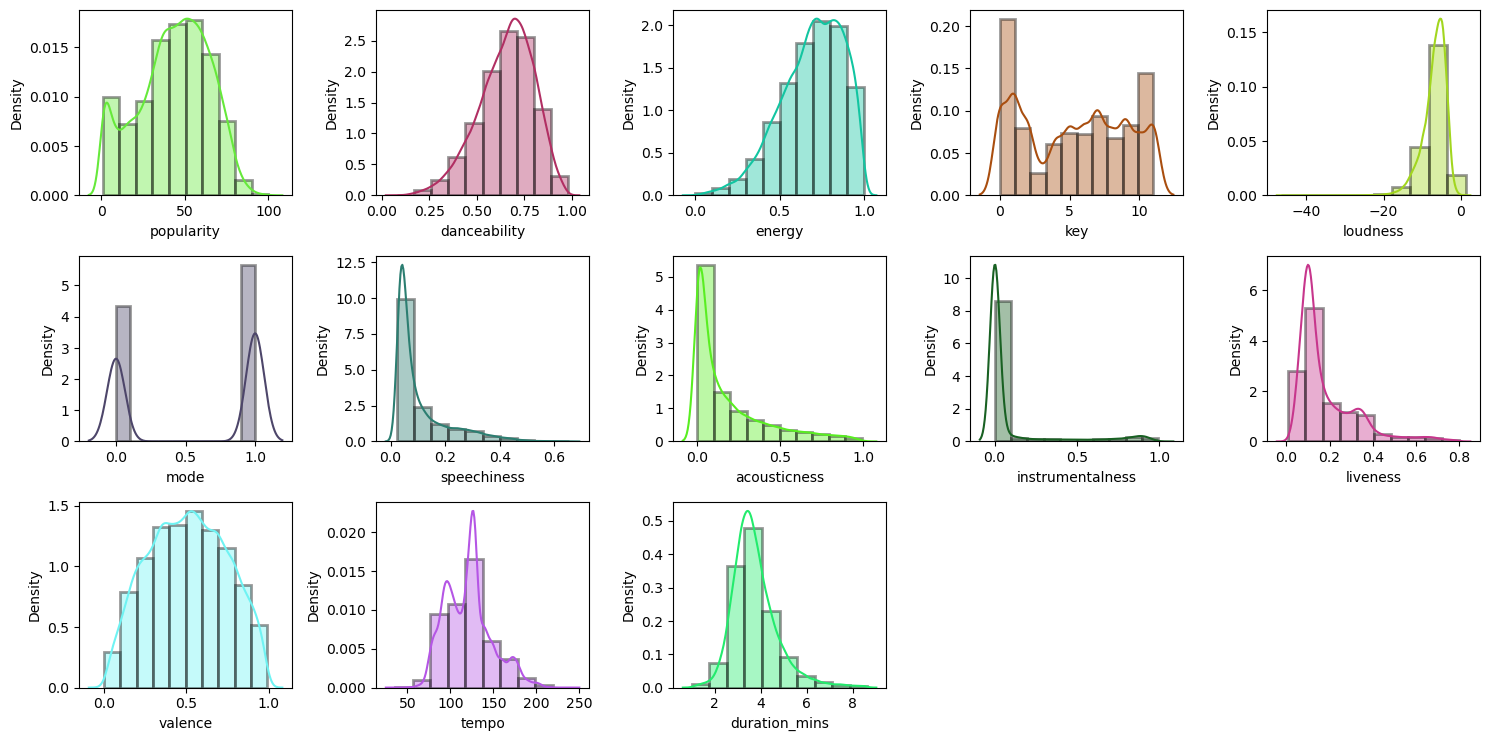

In [13]:
print('\033[1mNumeric Features Distribution'.center(100))

n = 5
numerical_columns = audiodf.select_dtypes(include='number')
cols = audiodf.select_dtypes(include='number').columns.tolist()
n_col = len(cols)

clr=['r','g','b','g','b','r']

plt.figure(
    figsize=[15,4*math.ceil(n_col/n)])

for i in range(n_col):
    plt.subplot(math.ceil(n_col/3),n,i+1)
    sns.distplot(audiodf[cols[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))

plt.tight_layout()
plt.show()

In [14]:
top_20_songs = audiodf.sort_values('popularity', ascending = False).copy().head(20)

                                 Numeric Features Distribution                                  


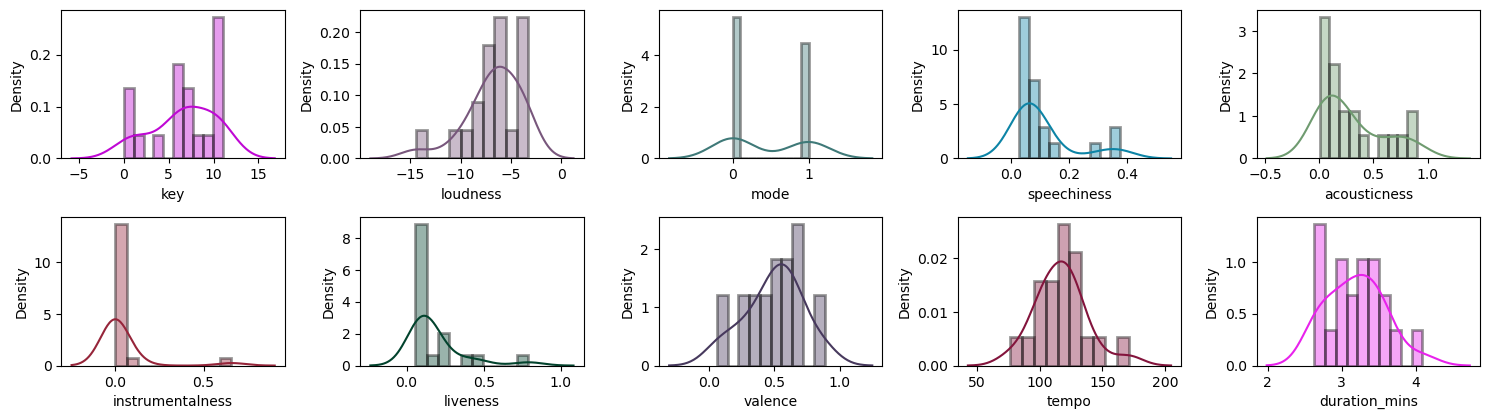

In [15]:
print('\033[1mNumeric Features Distribution'.center(100))

n = 5
cols = top_20_songs.select_dtypes(include='number').columns.tolist()[3:]
n_col = len(cols)

clr=['r','g','b','g','b','r']

plt.figure(
    figsize=[15,4*math.ceil(n_col/n)])

for i in range(n_col):
    plt.subplot(math.ceil(n_col/3),n,i+1)
    sns.distplot(top_20_songs[cols[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Average Traits of Top-Moderately-Low popular Songs'}>

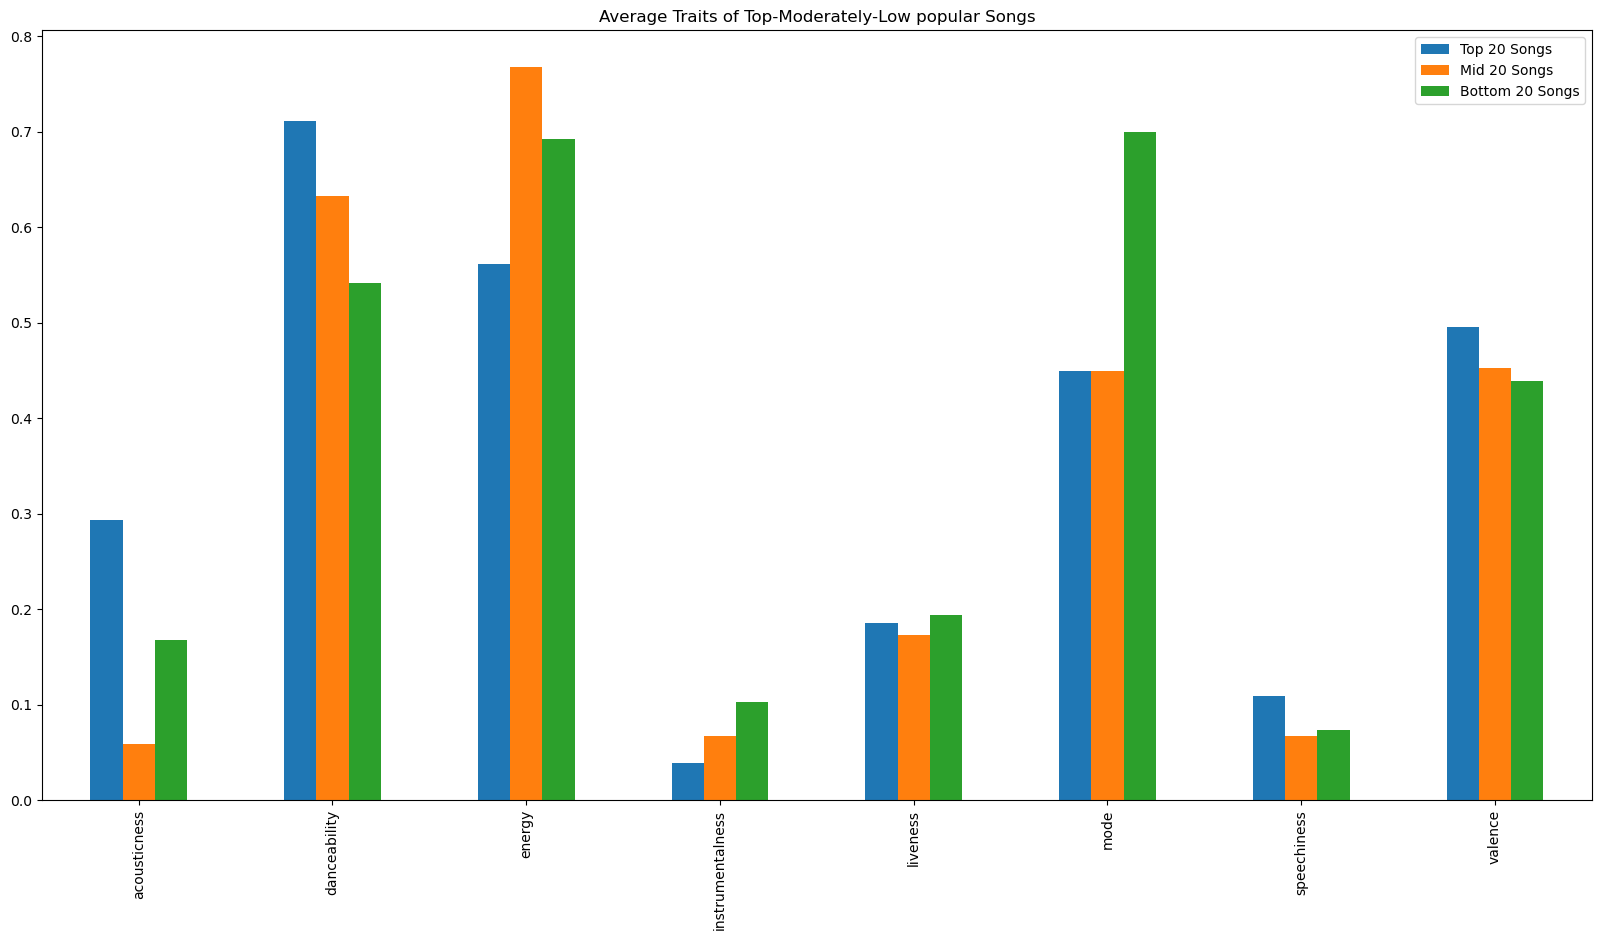

In [16]:
check = audiodf[audiodf['popularity'].between(audiodf['popularity'].quantile(0.45),audiodf['popularity'].quantile(0.55))]
check = check[['acousticness', 'danceability','energy', 'instrumentalness', 'liveness', 'mode','speechiness', 'valence']].head(20)
check = check.T
mid_20 = pd.DataFrame(check[check.columns].mean(axis = 1),columns = ['Mid 20 Songs'])

check = audiodf.sort_values(by = 'popularity',ascending=False).head(20)[['acousticness', 'danceability','energy', 'instrumentalness', 'liveness', 'mode','speechiness', 'valence']]
check = check.T
top_20 = pd.DataFrame(check[check.columns].mean(axis = 1),columns = ['Top 20 Songs'])

check = audiodf.sort_values(by = 'popularity',ascending=False).tail(20)[['acousticness', 'danceability','energy', 'instrumentalness', 'liveness', 'mode','speechiness', 'valence']]
check = check.T
bottom_20 = pd.DataFrame(check[check.columns].mean(axis = 1),columns = ['Bottom 20 Songs'])

top_bottom = pd.concat([top_20,mid_20, bottom_20], axis = 1)

top_bottom.plot(title = 'Average Traits of Top-Moderately-Low popular Songs', figsize=(20,10),linewidth=2,kind = 'bar' )

### Correlation Heatplot for numeric variables

<Axes: >

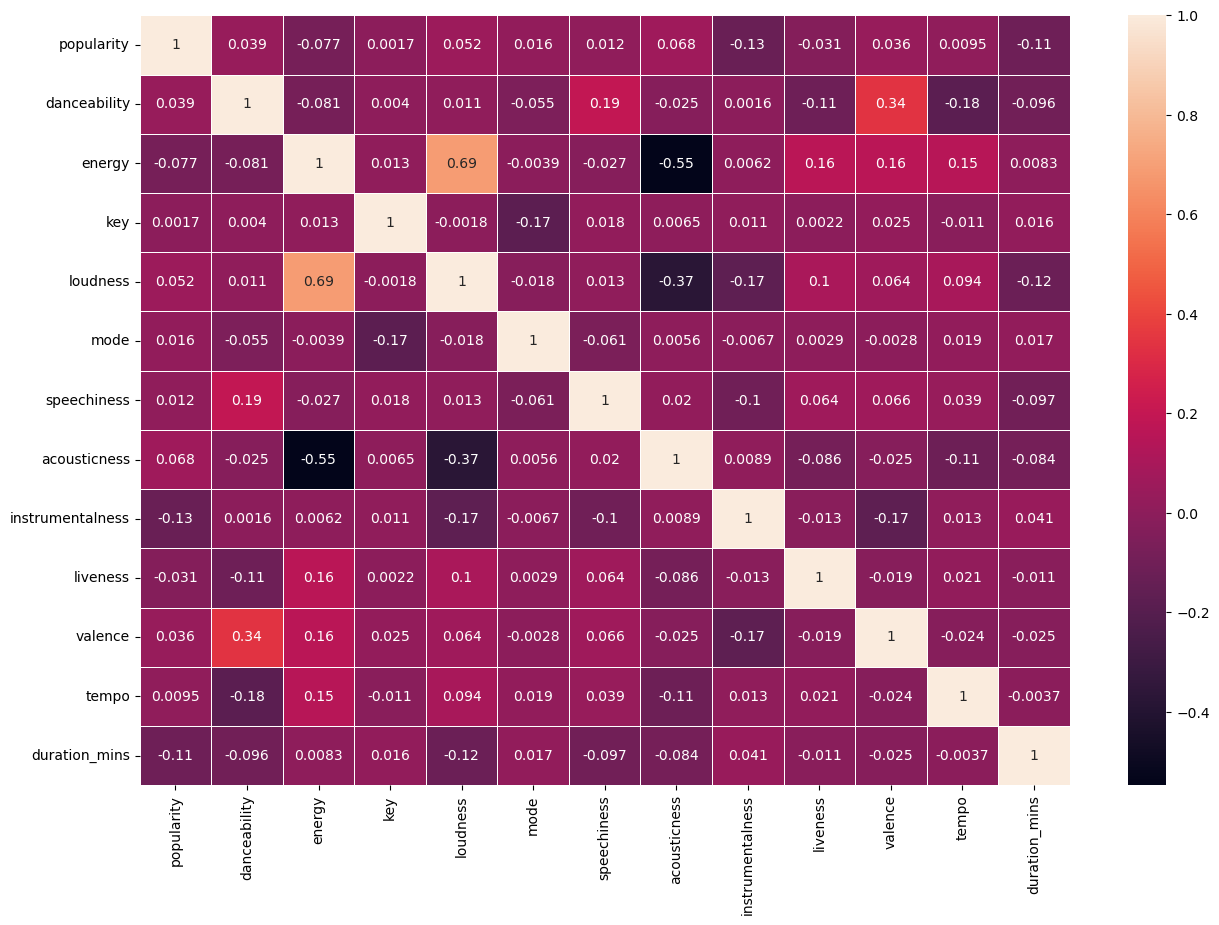

In [17]:
fig, ax = plt.subplots(figsize=(15,10))      
sns.heatmap(numerical_columns.corr(), annot=True,linewidths=.5, ax=ax)

*Remark*:
**We can observe that energy is highly correlated with loudness and acousticness. Thus, We are removing energy feature from the data.**

# Part 1. Training Neural Network

### Define X(input) and y(target) sets

In [36]:

X = audiodf.drop(columns=["track_id", "track_name", "track_artist", "track_album_id", "track_album_name", "track_album_release_date", "playlist_name", "playlist_id", "playlist_genre", "playlist_subgenre"])
y = audiodf["popularity"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
# Define the device to run on (use GPU if available, otherwise use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train.values.reshape(-1, 1)).to(device)

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test.values.reshape(-1, 1)).to(device)

# Split the data into training and validation sets
batch_size = 512
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

class NNModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(NNModel, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

# Set the hyperparameters
input_size = X_train.shape[1]
hidden_size1 = 256
hidden_size2 = 128
output_size = 1
learning_rate = 0.001
epochs = 500

# Initialize the model, loss function, and optimizer
model = NNModel(input_size, hidden_size1, hidden_size2, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = []
val_losses = []

# Training loop with batch processing and validation
for epoch in range(epochs):
    per_batch_losses = []
    per_batch_val_losses = []

    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        per_batch_losses.append(loss.item())

    losses.append(np.mean(per_batch_losses))

    # Validation
    model.eval()
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            per_batch_val_losses.append(val_loss.item())
        
        val_losses.append(np.mean(per_batch_val_losses))

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch [10/500], Loss: 13.1542, Val Loss: 13.5260
Epoch [20/500], Loss: 1.4165, Val Loss: 1.3237
Epoch [30/500], Loss: 0.4908, Val Loss: 0.3509
Epoch [40/500], Loss: 0.2526, Val Loss: 0.2401
Epoch [50/500], Loss: 0.2411, Val Loss: 0.1966
Epoch [60/500], Loss: 0.1814, Val Loss: 0.1607
Epoch [70/500], Loss: 0.1261, Val Loss: 0.1592
Epoch [80/500], Loss: 0.0862, Val Loss: 0.1420
Epoch [90/500], Loss: 0.0570, Val Loss: 0.1287
Epoch [100/500], Loss: 0.0671, Val Loss: 0.1191
Epoch [110/500], Loss: 0.0605, Val Loss: 0.1180
Epoch [120/500], Loss: 0.0458, Val Loss: 0.1092
Epoch [130/500], Loss: 0.0452, Val Loss: 0.0802
Epoch [140/500], Loss: 0.0359, Val Loss: 0.0738
Epoch [150/500], Loss: 0.0281, Val Loss: 0.0604
Epoch [160/500], Loss: 0.0272, Val Loss: 0.0495
Epoch [170/500], Loss: 0.0196, Val Loss: 0.0368
Epoch [180/500], Loss: 0.0194, Val Loss: 0.0336
Epoch [190/500], Loss: 0.0179, Val Loss: 0.0337
Epoch [200/500], Loss: 0.0136, Val Loss: 0.0294
Epoch [210/500], Loss: 0.0157, Val Loss: 0.0259

In [48]:


# Evaluate on the test set
model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(scaler.transform(X_test)).to(device)
    y_test_tensor = torch.FloatTensor(y_test.values.reshape(-1, 1)).to(device)

    y_pred = model(X_test_tensor)

### Training Loss

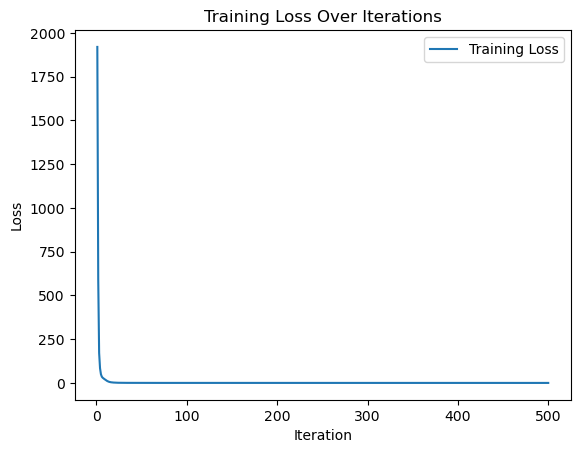

In [49]:
# Plot the training loss over iterations
plt.plot(range(1, epochs+1), losses, label='Training Loss')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Validation Loss

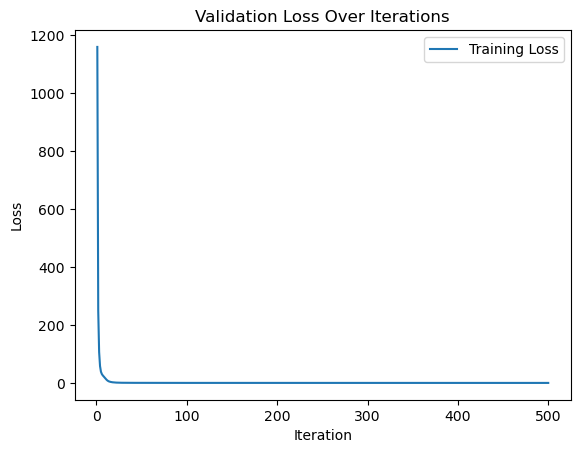

In [51]:
# Plot the training loss over iterations
plt.plot(range(1, epochs+1), val_losses, label='Training Loss')
plt.title('Validation Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model Evaluation

In [56]:
# Convert predictions and true values back to numpy arrays
y_pred_np = y_pred
y_test_np = y_test

# Compute regression metrics
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = mean_squared_error(y_test_np, y_pred_np, squared=False)

# Print or log the metrics
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

Mean Squared Error (MSE): 0.0058
Root Mean Squared Error (RMSE): 0.0762


# Part 2. Conformal Prediction

In [59]:
def splitData(x, y, n1):
    x = x.to(torch.device("cpu")).numpy()
    y = y.to(torch.device("cpu")).numpy()
    x1 = x[:n1]
    y1 = y[:n1]
    x2 = x[n1:]
    y2 = y[n1:]
    x1 = torch.FloatTensor(x1).to(device)
    y1 = torch.FloatTensor(y1.reshape(-1, 1)).to(device)
    x2 = torch.FloatTensor(x2).to(device)
    y2 = torch.FloatTensor(y2.reshape(-1, 1)).to(device)
    return x1, y1, x2, y2

In [65]:
n1 = int(X_train.shape[0] * 0.8)
input_size = X_train.shape[1]
hidden_size1 = 256
hidden_size2 = 128
output_size = 1
learning_rate = 0.001
#more epochs than above training for calibration
epochs = 5000
alpha = 0.05

# Splitting the train to get the residuals on calibrated train
xtrain1, ytrain1, xtrain2, ytrain2 = splitData(X_train_tensor, y_train_tensor, n1)

# Train the model on xtrain1
model = NNModel(input_size, hidden_size1, hidden_size2, output_size)
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

losses = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(xtrain1)
    loss = criterion(outputs, ytrain1)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate on the validation set
model.eval()
with torch.no_grad():
    val_outputs = model(xtrain2)
    val_loss = criterion(val_outputs, ytrain2)
    print(f'Validation Loss: {val_loss.item():.4f}')

Epoch [500/5000], Loss: 5.6260
Epoch [1000/5000], Loss: 0.4223
Epoch [1500/5000], Loss: 0.2149
Epoch [2000/5000], Loss: 0.1382
Epoch [2500/5000], Loss: 0.0918
Epoch [3000/5000], Loss: 0.0623
Epoch [3500/5000], Loss: 0.0458
Epoch [4000/5000], Loss: 0.0352
Epoch [4500/5000], Loss: 0.0278
Epoch [5000/5000], Loss: 0.0224
Validation Loss: 0.0444


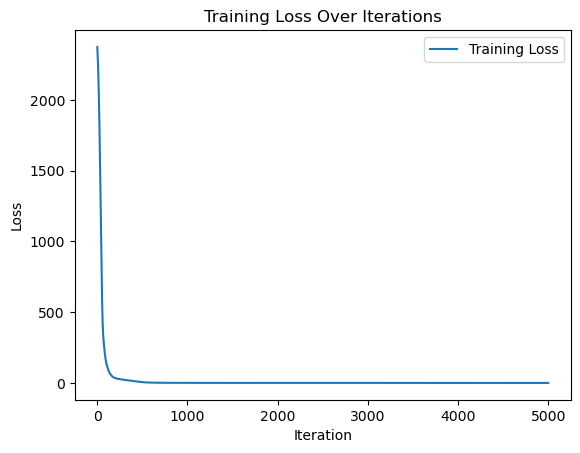

In [108]:
# Plot the training loss over iterations
plt.plot(range(1, epochs+1), losses, label='Training Loss')
plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

Final Training Loss: 0.0224 \
Final Validation Loss: 0.0444

In [109]:
preds = model(xtrain2).squeeze().detach().numpy().tolist()
labels = ytrain2.flatten().tolist()

resids = [labels[i] - preds[i] for i in range(len(labels))]

y_pred = model(X_test_tensor).squeeze().detach().numpy().tolist()

# intervals = conformalInterval(resids, y_pred, alpha)
quantile = np.quantile(resids, q=1-alpha, axis=0, interpolation='higher')

y_test_array = y_test.values.tolist()

# Now use y_test_array instead of y_test in your list comprehension
cov_test = [1 if y_test_array[i] >= y_pred[i] - quantile and y_test_array[i] <= y_pred[i] + quantile else 0 for i in range(len(y_test_array))]

print('Percent covered on test data: ', np.mean(cov_test))


Percent covered on test data:  0.8848055018267784


# Part 3 - Hypothesis Testing

In [111]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Convert data to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled).to(device)
y_tensor = torch.FloatTensor(y.values.reshape(-1, 1)).to(device)  # Convert Pandas Series to NumPy array

## 1. Independence Testing


Ho: There is no significance between input variables in predicting the popularity of the song

H1: There is significance between input variables in predicting the popularity of the song


In [123]:

n_samples = X_scaled.shape[0]

def trainer(x, y, net, epochs=500):
    
    net = net.to(device)

    optimizer = optim.Adam(net.parameters(), lr=0.01)
    for epoch in range(epochs):

        optimizer.zero_grad()
        outputs = net(x)
        
        loss = nn.MSELoss(reduction='mean')(outputs, y)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    return loss.item()


# 


# Perform permutation testing
n_permutations = 5
resampled_Ts = []

for p in range(n_permutations):
    print(f"--------Permutation Number : {p}------------")
    net = NNModel(input_size, hidden_size1,hidden_size2, output_size)
    permuted_Y = y_tensor[torch.randperm(n_samples)]
    resampled_T = trainer(X_tensor, permuted_Y, net = net)
    resampled_Ts.append(resampled_T)

--------Permutation Number : 0------------
Epoch [100/500], Loss: 447.7911
Epoch [200/500], Loss: 443.3317
Epoch [300/500], Loss: 441.3832
Epoch [400/500], Loss: 439.3678
Epoch [500/500], Loss: 436.7862
--------Permutation Number : 1------------
Epoch [100/500], Loss: 447.9117


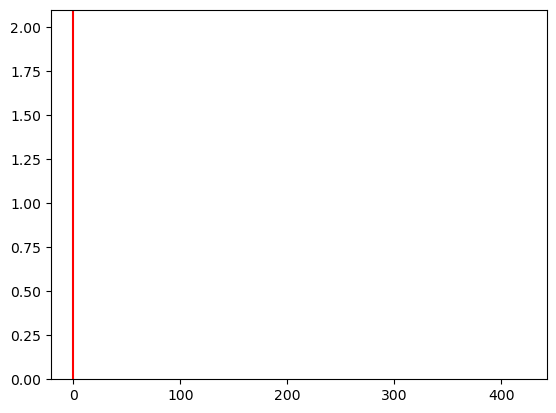

Observed test statistic: 0.0497
P-Value: 0.0000


In [118]:
obs_T = trainer(X_tensor, y_tensor)
# Calculate p-value
p_value = sum([1 for t in resampled_Ts if t <= obs_T]) / n_permutations

# plot distribution of permuted_test_statistics
plt.hist(resampled_Ts, bins=20)
plt.axvline(obs_T, color='red')
plt.show()


print(f"Observed test statistic: {obs_T:.4f}")
print(f"P-Value: {p_value:.4f}")

**Conclusion**

`p-value < 0.05`

hence we reject our null hypothesis, and conclude that based on our data, we have enough evidence to conclude that there is significance between the predictors in predicting the popularity of the song. 

`Reason to run hypothesis:` check if the predictors in our data have an effect on the song popularity.

# Hypothesis 2

H0: There is no difference in mean popularity between tracks in group A (mode 0) and group B (mode 1)

H1: There is a significant difference in mean popularity between tracks in group A (mode 0) and group B (mode 1).

In [119]:
n_samples = X_scaled.shape[0]
# Define the groups
group_A = X[X['mode']==0]
group_B = X[X['mode']==1]

# Calculate observed test statistic (mean popularity)
observed_statistic = group_A['popularity'].mean()

# Perform permutation testing
n_permutations = 1000
permuted_statistics = []

for _ in range(n_permutations):
    shuffled_keys = np.random.permutation(X['mode'])
    df_permuted = X.copy()
    df_permuted['mode'] = shuffled_keys
    permuted_statistic = df_permuted[df_permuted['mode']==0]['popularity'].mean()
    permuted_statistics.append(permuted_statistic)

# Calculate p-value
p_value = np.mean(permuted_statistics >= observed_statistic)
print(f"Observed Test Statistic: {observed_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

Observed Test Statistic: 43.4921
P-value: 0.9800


**Conclusion** 

`p-value > 0.05`

hence we can fail to reject our null hypothesis, and conclude that based on our data, we have enough evidence to conclude that there is no difference in mean popularity between tracks in group A (mode 0) and group B (mode 1).

`Reason to run hypothesis:` Check if the mode of the song track has any effect on the popularity of the song